In [52]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from src.data import get_dataset
from src.features import get_preprocessor
from src.models import search_model


In [53]:
def print_score(m, *, X_train, y_train, X_valid, y_valid):
    res = {"r2_train": m.score(X_train, y_train), "r2_valid": m.score(X_valid, y_valid)}
    print(res)


def plot_importances(m, columns):
    importances = m.feature_importances_
    std = np.std([tree.feature_importances_ for tree in m], axis=0)

    forest_importances = pd.Series(importances, index=columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()


In [54]:
RAW_DATA_PATH = "../data/raw/olx_house_price_Q122.csv"
target = "price"


In [55]:
df = get_dataset(RAW_DATA_PATH)


In [56]:
df.dtypes

price                     float32
offer_type                 object
floor                     float32
area                      float32
rooms                        int8
offer_type_of_building     object
market                     object
longitude                 float32
latitude                  float32
city_name                  object
population                float32
voivodeship                object
dtype: object

In [57]:
X = df.drop(target, axis=1)
y = df[target]

preprocessor = get_preprocessor(df=X)
X = preprocessor.transform(X)

# reduce dataset size
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.70)
# split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.30)


In [58]:
preprocessor.get_feature_names_out()


array(['num__longitude', 'num__latitude', 'num__area', 'num__population',
       'ordinal__rooms', 'ordinal__offer_type',
       'ordinal__offer_type_of_building', 'ordinal__market',
       'ordinal__floor'], dtype=object)

In [59]:
model = search_model(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [60]:
model


TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_features=0.5,
                                                           min_samples_leaf=3,
                                                           min_samples_split=4,
                                                           n_estimators=60,
                                                           n_jobs=-1))

{'r2_train': 0.8000094461946801, 'r2_valid': 0.0009121517290798797}


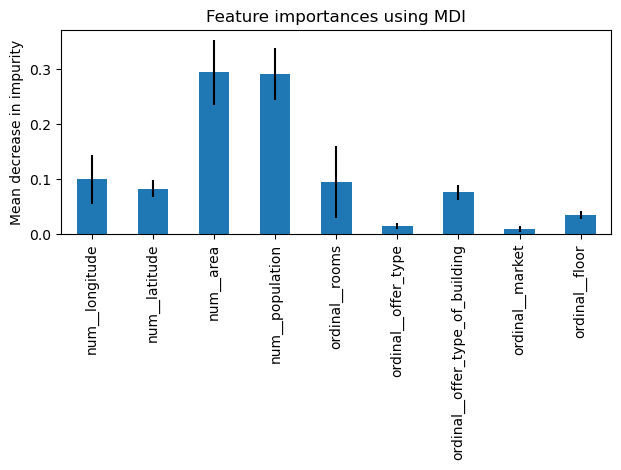

In [61]:
print_score(
    model,
    X_train=X_train,
    X_valid=X_valid,
    y_train=y_train,
    y_valid=y_valid,
)
plot_importances(model.regressor_, preprocessor.get_feature_names_out())


In [62]:
pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("model", model)])


In [63]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20
)


In [64]:
pipeline.score(X_valid, y_valid)


0.6992576434105403

In [65]:
index = 5258

request = X_valid.iloc[index].to_dict()
true_price = y_valid.iloc[index]
request


{'offer_type': 'Estate Agency',
 'floor': 8.0,
 'area': 44.0,
 'rooms': 3,
 'offer_type_of_building': 'Housing Block',
 'market': 'aftermarket',
 'longitude': 19.02158546447754,
 'latitude': 50.2598991394043,
 'city_name': 'Katowice',
 'population': 304362.0,
 'voivodeship': 'Silesia'}

In [66]:
single_X = pd.DataFrame({k: [v] for k, v in request.items()})
print(f"predicted={pipeline.predict(single_X)[0]:.2f}, {true_price=}")


predicted=336487.34, true_price=312000.0


In [67]:
loaded_model = joblib.load("ml/models/2022-11-17_05:57:50_score(0.800).pkl")

In [68]:
print(f"predicted={loaded_model.predict(single_X)[0]:.2f}, {true_price=}")

predicted=311961.11, true_price=312000.0
